In [1]:
example = "01"

import random

import os
import shutil
import numba
from random import randint

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy import linalg
from scipy import fftpack
from scipy import stats
from sklearn.preprocessing import normalize, MinMaxScaler
import scipy.signal as sgn
import scipy.misc
from scipy.special import logsumexp as sp_logsumexp

from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import sklearn.metrics

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot

from statsmodels.tsa.stattools import grangercausalitytests as granger
#from statsmodels.sandbox.distributions.mv_measures import mutual_info_kde

from scipy.stats import gaussian_kde
def mutualinfo_kde(y, x, normed=True):
    '''mutual information of two random variables estimated with kde
    '''
    nobs = len(x)
    if not len(y) == nobs:
        raise ValueError('both data arrays need to have the same size')
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    yx = np.vstack((y,x))
    kde_x = gaussian_kde(x)(x)
    kde_y = gaussian_kde(y)(y)
    kde_yx = gaussian_kde(yx)(yx)

    mi_obs = np.log(kde_yx) - np.log(kde_x) - np.log(kde_y)
    mi = mi_obs.sum() / nobs
    if normed:
        mi_normed = np.sqrt(1. - np.exp(-2 * mi))
        return mi_normed
    else:
        return mi

    # Define functions
# import transfer entropy function from R:

# calculate distance matrix from position matrix
def distanceMatrix(plist):
    n = np.shape(plist)[0]
    dmat = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            dmat[i,j] = np.linalg.norm(POSITIONS[i]-POSITIONS[j])
    return(dmat)

# calculate undirected adjacency matrix
def connectionMatrix(fmat, nlist):
    n = np.shape(fmat)[1]
    cmat = np.zeros((n,n))
    for connection in nlist:
        nfrom = connection[0] - 1
        nto = connection[1] - 1
        if connection[2] != 0:
            cmat[nfrom, nto] = 1
            cmat[nto, nfrom] = 1
    return(cmat)

# calculate directed adjacency matrix
def projectionMatrix(fmat, nlist):
    n = np.shape(fmat)[1]
    pmat = np.zeros((n,n))
    for connection in nlist:
        nfrom = connection[0] - 1
        nto = connection[1] - 1
        ctype = connection[2]
        pmat[nfrom, nto] = ctype
    return(pmat)

def spike_detect(flr, h=0.125, w=3):
    s = np.zeros(np.shape(flr))
    for j in range(np.shape(flr)[1]):
        t = sgn.find_peaks(flr[:,j],
                           h,
                           width=w) 
        for i in t[0]:
            s[i,j] = 1
    return(s)

def lp_1(track):    
    # attempt hp on 2d matrix
    try:
        new_track = np.zeros((np.shape(track)[0], np.shape(track)[1]))
        for i in range(np.shape(track)[0]):
            for j in range(np.shape(track)[1]):
                try:
                    new_track[i,j] = (track[i-1,j] + track[i,j] + track[i+1],j)     
                except:
                    new_track[i,j] = track[i,j]
    
    # if dimensional error, hp 1 dimensional
    except:       
        new_track = np.zeros(len(track))
        for i in range(len(track)):
            try:
                new_track[i] = (track[i-1] + track[i] + track[i+1])     
            except:
                new_track[i] = track[i]
    return(new_track)

def lp_2(track): 
    try:# attempt hp on 2d matrix
        new_track = np.zeros((np.shape(track)[0], np.shape(track)[1]))
        for i in range(np.shape(track)[0]):
            for j in range(np.shape(track)[1]):
                try:
                    new_track[i,j] = (0.4* track[i-3,j] + 0.6*track[i-2,j] + 0.8*track[i-1,j] + track[i,j])     
                except:
                    new_track[i,j] = track[i,j]       
    except:# if dimensional error, hp 1 dimensional
        new_track = np.zeros(len(track))
        for i in range(len(track)):
            try:
                new_track[i] = (0.4* track[i-3] + 0.6*track[i-2] + 0.8*track[i-1] + track[i])     
            except:
                new_track[i] = track[i]
    return(new_track)

def hp(track):
    try:# attempt lp on 2d matrix
        new_track = np.zeros((np.shape(track)[0], np.shape(track)[1]))
        for i in range(np.shape(track)[0]):
            for j in range(np.shape(track)[1]):
                try:
                    new_track[i,j] = track[i,j] - track[i-1,j]
                except:
                    new_track[i,j] = track[i,j]    
    except:
        new_track = np.zeros(len(track))
        for i in range(len(track)):
            try:
                new_track[i] = track[i] - track[i-1]
            except:
                new_track[i] = track[i]         
    return(new_track)

def weight_filt(track):    
    new_track = new_track = np.zeros((np.shape(track)[0], np.shape(track)[1]))
    for i in range(np.shape(track)[0]):
        for j in range(np.shape(track)[1]):
            new_track[i,j] = (track[i,j] + 1) ** (1 + (1 / np.sum(track[i, :])))
    return(new_track)
    


def thresh(track, th=0.05):
    try:# attempt threshold on 2d matrix
        new_track = np.zeros((np.shape(track)[0], np.shape(track)[1]))
        for i in range(np.shape(track)[0]):
            for j in range(np.shape(track)[1]):
                if track[i,j] < th:
                    new_track[i,j] = 0
                else:
                    new_track[i,j] = track[i,j]
    except:# threshold 1d track
        new_track = np.zeros(len(track))
        for i in range(len(track)):
            if track[i] < th:
                new_track[i] = 0
            else:
                new_track[i] = track[i]
    return(new_track)

def all_filter(track):
    track = weight_filt((thresh(lp(hp_2(hp_1(track))))))
    return(track)

def pc(mat):
    p = np.zeros((np.shape(mat)[1], np.shape(mat)[1]))
    prec = linalg.inv(np.cov(mat, rowvar = False))
    for i in range((np.shape(p)[0])):
        for j in range((np.shape(p)[1])):
            p[i, j] = -1 * prec[i,j] / (np.sqrt(prec[i,i]*prec[j,j]))
    return(p)

def mutual_info(matrix, window=50):
    n = np.shape(matrix)[1]
    MImat = np.zeros((n,n))
    periods = []
    for i in range(0, int(np.floor(np.shape(matrix)[0] / window)-1)):
        periods.append([i*window, (i+1)*window])
            
    for i in range(0,n):
        for j in range(0,n):
            MI = []
            for p in periods:
                #print("i={}, j={},p={}".format(i,j,p))
                if i!=j:
                    info = mutual_info_classif(matrix[p[0]:p[1],i].reshape(-1,1), 
                                                  matrix[p[0]:p[1],j],
                                                  n_neighbors=5, 
                                                  discrete_features=True)*1000
                    MI.append(info)
                else:
                    MI.append(0)
                
                #print("{},{}: {}".format(i,j,MI))
            MImat[i,j] = (np.quantile(MI,.75))
    return(MImat)


def grangerMatrix(matrix, mem = 5):
    # pass a spike train matrix
    n = np.shape(matrix)[1]
    gMat = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if i!=j:
                f = []
                c = matrix[:,(i,j)]
                g = granger(c, maxlag = mem, verbose=False)
                for k in g.keys():
                    f.append(g[k][0]['ssr_ftest'][0])
                gMat[i,j] = max(f)
    return(gMat)



def upper_thresh(matrix, th = 15):
    for i in range(np.shape(matrix)[0]):
        for j in range(np.shape(matrix)[1]):
            if matrix[i,j]>th:
                matrix[i,j]=th
    return(matrix)

import pyitlib as itl
from pyitlib import discrete_random_variable as drv

def mutual_information_conditional(matrix):
    n = np.shape(matrix)[1]
    MIC = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if i!=j:
                print("{},{}".format(i,j))
                t[i,j] = drv.information_mutual_conditional(SPK_FLR[:,i], 
                                                            SPK_FLR[:,j], 
                                                            np.mean(np.delete(SPK_FLR[:,:],
                                                                              [i,j],
                                                                              axis=1), 
                                                                    axis=1))
    return(MIC)
               



# proj_dir = "/gpfs/scratch/dmc421/ML/connect/"
# src_dir = "{}src/".format(proj_dir)
# data_dir = "{}data/".format(proj_dir)
# mat_dir = "{}mat/".format(proj_dir)

# ffile = "flr_{}.txt".format(example)
# nfile = "net_{}.txt".format(example)
# pfile = "pos_{}.txt".format(example)

# fpath = "{}{}".format(src_dir, ffile)
# npath = "{}{}".format(src_dir, nfile)
# ppath = "{}{}".format(src_dir, pfile)


parent_path = "/Users/David/Documents/NYU/MACHINE_LEARNING/netconnect/"
source_path = "/Users/David/Documents/NYU/MACHINE_LEARNING/netconnect/src/"
data_path = "/Users/David/Documents/NYU/MACHINE_LEARNING/netconnect/data/"


ffile = "fluorescence_iNet1_Size100_CC01inh.txt"
nfile = "network_iNet1_Size100_CC01inh.txt"
pfile = 'networkPositions_iNet1_Size100_CC01inh.txt'

fpath = "{}{}".format(source_path, ffile)
npath = "{}{}".format(source_path, nfile)
ppath = "{}{}".format(source_path, pfile)


train_dir = "{}{}".format(data_path, "train/")
validation_dir = "{}{}".format(data_path, "validation/")
test_dir = "{}{}".format(data_path, "test/")




#Import data
# Import data
FLR = np.genfromtxt(fpath,
                    delimiter=',')
NETWORK = np.genfromtxt(npath,
                        delimiter=',').astype(int)
POSITIONS = np.genfromtxt(ppath,
                          delimiter=',')

CONNECTIONS = connectionMatrix(FLR, NETWORK)

PROJECTIONS = projectionMatrix(FLR, NETWORK)

DISTANCES = distanceMatrix(POSITIONS)



# Process FLR data to weight-adjusted

scaler = MinMaxScaler()

# freq filters
FFLR = hp(lp_2(lp_1(FLR)))
#[0,1] normalization
scale = scaler.fit(FFLR)
FFLR = scale.transform(FFLR)
# weight and thresholding
WFLR = weight_filt(FFLR)
WFLR = upper_thresh(WFLR)
# spike detection
SPK_FLR=spike_detect(WFLR, h = .1)




In [176]:
l = np.shape(FLR)[0]
window=10000
lh = 15000
rh = l-window-2
avg = np.mean(FLR, axis=1)

start = randint(lh, rh)
stop = start + window
while (any in FLR[start:stop, :] > np.quantile(avg,0.8)):
    start = randint(lh, rh)
    stop = start + window
    
print("{},{}".format(start,stop))
n = np.shape(FLR)[1]
MI = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        
        
        print("{},{}".format(i,j))
        if i!=j:
            try:
                MI[i,j] = mutualinfo_kde(SPK_FLR[start:stop,i], SPK_FLR[start:stop,j])
            except:
                MI[i,j] = 0


35402,45402
0,0
0,1


/miniconda3/envs/connectomics/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in sqrt


0,2
0,3
0,4
0,5
0,6
0,7
0,8
0,9
1,0
1,1
1,2
1,3
1,4
1,5
1,6
1,7
1,8
1,9
2,0
2,1
2,2
2,3
2,4
2,5
2,6
2,7
2,8
2,9
3,0
3,1
3,2
3,3
3,4
3,5
3,6
3,7
3,8
3,9
4,0
4,1
4,2
4,3
4,4
4,5
4,6
4,7
4,8
4,9
5,0
5,1
5,2
5,3
5,4
5,5
5,6
5,7
5,8
5,9
6,0
6,1
6,2
6,3
6,4
6,5
6,6
6,7
6,8
6,9
7,0
7,1
7,2
7,3
7,4
7,5
7,6
7,7
7,8
7,9
8,0
8,1
8,2
8,3
8,4
8,5
8,6
8,7
8,8
8,9
9,0
9,1
9,2
9,3
9,4
9,5
9,6
9,7
9,8
9,9


/miniconda3/envs/connectomics/lib/python3.7/site-packages/ipykernel_launcher.py:100: PeakPropertyWarning: some peaks have a width of 0


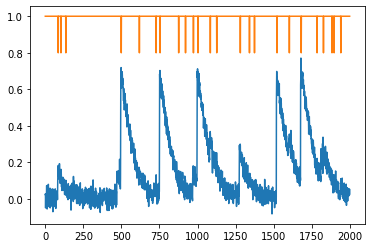

In [32]:
np.savetxt("{}MI_{}".format(mat_dir,example), MI, delimiter="," )

array([[ 1.,  2.],
       [ 4.,  5.],
       [11., 17.],
       [10., 10.]])